# **Klasifikasi Gambar Sampah organik dan anorganik**


## **Sumber Dataset**
https://www.kaggle.com/datasets/techsash/waste-classification-data

## Import Semua Packages/Library yang Digunakan

In [43]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import skimage
from skimage.exposure import adjust_gamma
from skimage.util import img_as_ubyte
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import joblib
import pickle
import zipfile
import random
from collections import Counter
from google.colab import files
import cv2

## Data Preparation

### Data Loading

In [6]:
# Upload file kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"synjoestar","key":"cc2ece4b04fbbc8f0bf1e1d15c24c861"}'}

In [7]:
# Hapus dataset lama jika ada
!rm -rf waste_classification_data/ waste-classification-data.zip

# Setup Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset dari Kaggle
!kaggle datasets download -d techsash/waste-classification-data

# Unzip dataset ke dalam folder waste_classification_data
!unzip -q waste-classification-data.zip -d waste_classification_data

# Hapus file zip untuk menghemat penyimpanan
!rm waste-classification-data.zip

Dataset URL: https://www.kaggle.com/datasets/techsash/waste-classification-data
License(s): CC-BY-SA-4.0


In [9]:
import os
from PIL import Image  # Untuk validasi gambar

# Path dataset utama
dataset_path = "/content/waste_classification_data/DATASET"
train_path = os.path.join(dataset_path, "TRAIN")
test_path = os.path.join(dataset_path, "TEST")

# List kelas dalam dataset (hanya folder, bukan file)
classes = [c for c in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, c))]

print(f"Jumlah kelas yang valid: {len(classes)}")
print(f"Kelas yang tersedia: {classes}")

# Mengecek jumlah gambar dalam setiap kelas di TRAIN dan TEST
total_images = {"TRAIN": 0, "TEST": 0}  # Menyimpan total gambar per split

for split, path in zip(["TRAIN", "TEST"], [train_path, test_path]):
    print(f"\nDataset: {split}")
    split_total = 0  # Total gambar per split
    for c in classes:
        num_images = len(os.listdir(os.path.join(path, c)))  # Hitung file dalam folder kelas
        print(f"Kelas {c}: {num_images} gambar")
        split_total += num_images
    total_images[split] = split_total

print(f"\nTotal gambar di TRAIN: {total_images['TRAIN']}")
print(f"Total gambar di TEST: {total_images['TEST']}")

# Validasi semua gambar di TRAIN dan TEST (pastikan file bukan corrupt)
corrupt_count = 0  # Hitung jumlah gambar rusak

for split, path in zip(["TRAIN", "TEST"], [train_path, test_path]):
    print(f"\nMemeriksa gambar di {split}...")
    for c in classes:
        class_path = os.path.join(path, c)
        for idx, img_name in enumerate(os.listdir(class_path), 1):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path)
                img.verify()  # Cek apakah file gambar rusak
            except Exception as e:
                print(f"[❌] Masalah dengan {img_path}: {e}")  # Jika error, cetak path dan error
                corrupt_count += 1
            if idx % 500 == 0:
                print(f"  ✅ {idx} gambar diperiksa di kelas {c}...")  # Indikator progress setiap 500 gambar

print(f"\nTotal gambar yang rusak: {corrupt_count}")  # Laporan akhir

Jumlah kelas yang valid: 2
Kelas yang tersedia: ['R', 'O']

Dataset: TRAIN
Kelas R: 9999 gambar
Kelas O: 12565 gambar

Dataset: TEST
Kelas R: 1112 gambar
Kelas O: 1401 gambar

Total gambar di TRAIN: 22564
Total gambar di TEST: 2513

Memeriksa gambar di TRAIN...
  ✅ 500 gambar diperiksa di kelas R...
  ✅ 1000 gambar diperiksa di kelas R...
  ✅ 1500 gambar diperiksa di kelas R...
  ✅ 2000 gambar diperiksa di kelas R...
  ✅ 2500 gambar diperiksa di kelas R...
  ✅ 3000 gambar diperiksa di kelas R...
  ✅ 3500 gambar diperiksa di kelas R...
  ✅ 4000 gambar diperiksa di kelas R...
  ✅ 4500 gambar diperiksa di kelas R...
  ✅ 5000 gambar diperiksa di kelas R...
  ✅ 5500 gambar diperiksa di kelas R...
  ✅ 6000 gambar diperiksa di kelas R...
  ✅ 6500 gambar diperiksa di kelas R...
  ✅ 7000 gambar diperiksa di kelas R...
  ✅ 7500 gambar diperiksa di kelas R...
  ✅ 8000 gambar diperiksa di kelas R...
  ✅ 8500 gambar diperiksa di kelas R...
  ✅ 9000 gambar diperiksa di kelas R...
  ✅ 9500 gambar dip

In [11]:
def check_images(path, classes):
    """
    Fungsi untuk memeriksa validitas gambar dalam dataset.

    Parameters:
    - path (str): Path ke dataset (TRAIN atau TEST).
    - classes (list): List nama kelas yang terdapat dalam dataset.
    """
    print(f"\n🔍 Memeriksa gambar di {path}...")
    total_checked = 0  # Total gambar yang diperiksa
    total_corrupt = 0  # Total gambar yang rusak

    for c in classes:
        class_path = os.path.join(path, c)
        num_images = len(os.listdir(class_path))  # Hitung jumlah gambar di kelas ini
        print(f"\n📂 Kelas: {c} ({num_images} gambar)")

        for idx, img_name in enumerate(os.listdir(class_path), 1):
            img_path = os.path.join(class_path, img_name)
            try:
                # Cek apakah file bisa dibuka (pastikan tidak corrupt)
                img = Image.open(img_path)
                img.verify()  # Hanya mengecek file, tidak memuat ke memori

                # Pastikan gambar bisa dibaca ulang dalam format RGB
                img = Image.open(img_path).convert("RGB")

                # Resize gambar ke 224x224 untuk simulasi preprocessing
                img.resize((224, 224))

            except Exception as e:
                print(f"❌ [ERROR] {img_path}: {e}")  # Cetak error jika ada masalah
                total_corrupt += 1

            # Cetak progress setiap 500 gambar
            if idx % 500 == 0:
                print(f"   ✅ {idx}/{num_images} gambar diperiksa...")

        total_checked += num_images

    print(f"\n✅ Total gambar diperiksa: {total_checked}")
    print(f"❌ Total gambar bermasalah: {total_corrupt}\n")

# Periksa gambar dalam dataset TRAIN dan TEST
check_images(train_path, classes)
check_images(test_path, classes)



🔍 Memeriksa gambar di /content/waste_classification_data/DATASET/TRAIN...

📂 Kelas: R (9999 gambar)
   ✅ 500/9999 gambar diperiksa...
   ✅ 1000/9999 gambar diperiksa...
   ✅ 1500/9999 gambar diperiksa...
   ✅ 2000/9999 gambar diperiksa...
   ✅ 2500/9999 gambar diperiksa...
   ✅ 3000/9999 gambar diperiksa...
   ✅ 3500/9999 gambar diperiksa...
   ✅ 4000/9999 gambar diperiksa...
   ✅ 4500/9999 gambar diperiksa...
   ✅ 5000/9999 gambar diperiksa...
   ✅ 5500/9999 gambar diperiksa...
   ✅ 6000/9999 gambar diperiksa...
   ✅ 6500/9999 gambar diperiksa...
   ✅ 7000/9999 gambar diperiksa...
   ✅ 7500/9999 gambar diperiksa...
   ✅ 8000/9999 gambar diperiksa...
   ✅ 8500/9999 gambar diperiksa...
   ✅ 9000/9999 gambar diperiksa...
   ✅ 9500/9999 gambar diperiksa...

📂 Kelas: O (12565 gambar)
   ✅ 500/12565 gambar diperiksa...
   ✅ 1000/12565 gambar diperiksa...
   ✅ 1500/12565 gambar diperiksa...
   ✅ 2000/12565 gambar diperiksa...
   ✅ 2500/12565 gambar diperiksa...
   ✅ 3000/12565 gambar diperi

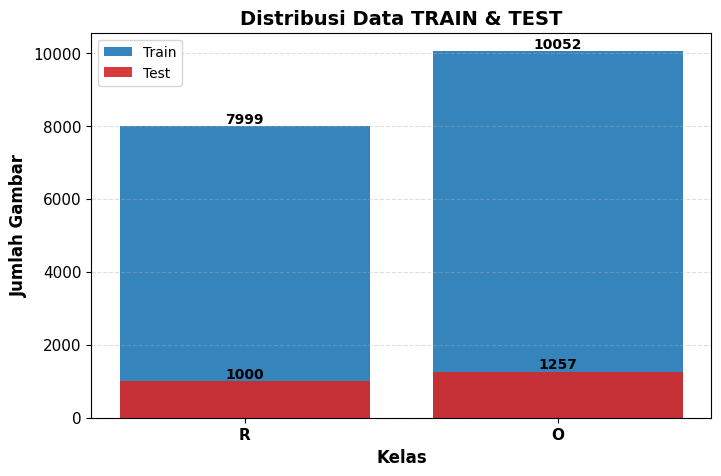

In [25]:
# Cek distribusi data
train_counts = [len(os.listdir(os.path.join(train_path, c))) for c in classes]
test_counts = [len(os.listdir(os.path.join(test_path, c))) for c in classes]

# Warna merah & biru yang lebih modern
train_color = "#1F77B4"  # Biru deep (stabil, readable)
test_color = "#D62728"   # Merah deep (kontras, tegas)

# Buat plot distribusi
plt.figure(figsize=(8, 5))
bars1 = plt.bar(classes, train_counts, color=train_color, alpha=0.9, label="Train")
bars2 = plt.bar(classes, test_counts, color=test_color, alpha=0.9, label="Test")

# Tambahkan angka di atas setiap bar
for bar in bars1 + bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{bar.get_height()}", ha='center', va='bottom',
             fontsize=10, fontweight="bold", color="black")

# Elemen visual tambahan biar clean
plt.xlabel("Kelas", fontsize=12, fontweight="bold")
plt.ylabel("Jumlah Gambar", fontsize=12, fontweight="bold")
plt.title("Distribusi Data TRAIN & TEST", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(axis='y', linestyle="--", alpha=0.4)  # Grid soft, nggak ganggu
plt.xticks(fontsize=11, fontweight="bold")  # Font sumbu X biar lebih jelas
plt.yticks(fontsize=11)

plt.show()


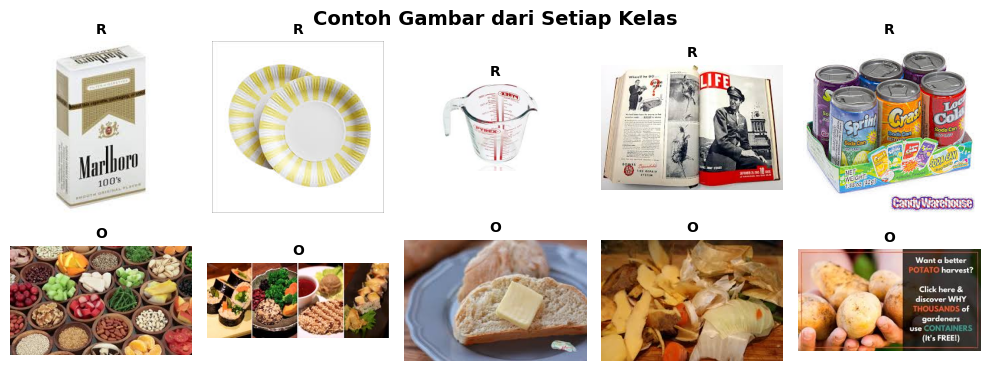

In [21]:
# Fungsi untuk menampilkan sample gambar dari setiap kelas
def show_sample_images(path, classes, num_samples=5):
    fig, axes = plt.subplots(nrows=len(classes), ncols=num_samples, figsize=(num_samples * 2, len(classes) * 2))

    for i, c in enumerate(classes):
        class_path = os.path.join(path, c)
        sample_images = random.sample(os.listdir(class_path), num_samples)  # Ambil 5 gambar random

        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)

            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            axes[i, j].set_title(f"{c}", fontsize=10, fontweight="bold")

    # Supaya judul nggak kepotong & lebih clean
    plt.suptitle("Contoh Gambar dari Setiap Kelas", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Naikkan judul sedikit biar nggak nabrak
    plt.show()

# Tampilkan sample gambar dari TRAIN set
show_sample_images(train_path, classes, num_samples=5)


### Data Preprocessing

#### Split Dataset

In [22]:
# Path dataset utama
dataset_path = "/content/waste_classification_data/DATASET"
train_source_path = os.path.join(dataset_path, "TRAIN")
test_source_path = os.path.join(dataset_path, "TEST")

# Path dataset baru
train_path = "/content/dataset/train"
val_path = "/content/dataset/val"
test_path = "/content/dataset/test"

# Buat folder train, val, test
for path in [train_path, val_path, test_path]:
    os.makedirs(path, exist_ok=True)

# Fungsi preprocessing dengan OpenCV
def preprocess_image(image_path):
    """
    Preprocessing gambar dengan grayscale, blur, edge detection, dan watershed segmentation.
    """
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Grayscale

    # Gaussian Blur untuk stabilisasi
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)

    # Canny Edge Detection
    edges = cv2.Canny(img_blur, 50, 150)

    # Watershed segmentation
    ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Label markers
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]  # Warna merah untuk boundary

    return img

# Split dataset dari TRAIN
for category in os.listdir(train_source_path):
    class_path = os.path.join(train_source_path, category)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)

        if len(images) > 1:
            # **Split data: Train 80%, Val 10%, Test 10%**
            train_images, temp_images = train_test_split(images, test_size=0.20, random_state=42)
            val_images, test_images = train_test_split(temp_images, test_size=0.50, random_state=42)
        else:
            train_images, val_images, test_images = images, [], []

        # Buat folder per kelas
        for path in [train_path, val_path, test_path]:
            os.makedirs(os.path.join(path, category), exist_ok=True)

        # Pindahkan gambar ke folder masing-masing
        def move_images(image_list, src_path, dest_path, category):
            for img in image_list:
                img_path = os.path.join(src_path, img)
                processed_img = cv2.imread(img_path)  # Bisa tambahin preprocess_image(img_path) kalau mau preprocessing
                cv2.imwrite(os.path.join(dest_path, category, img), processed_img)

        move_images(train_images, class_path, train_path, category)
        move_images(val_images, class_path, val_path, category)
        move_images(test_images, class_path, test_path, category)

        print(f"✅ Kelas {category}: Train ({len(train_images)}), Val ({len(val_images)}), Test ({len(test_images)})")

print("\n🎯 Dataset berhasil diproses! Train: 80%, Val: 10%, Test: 10%.")

✅ Kelas R: Train (7999), Val (1000), Test (1000)
✅ Kelas O: Train (10052), Val (1256), Test (1257)

🎯 Dataset berhasil diproses! Train: 80%, Val: 10%, Test: 10%.


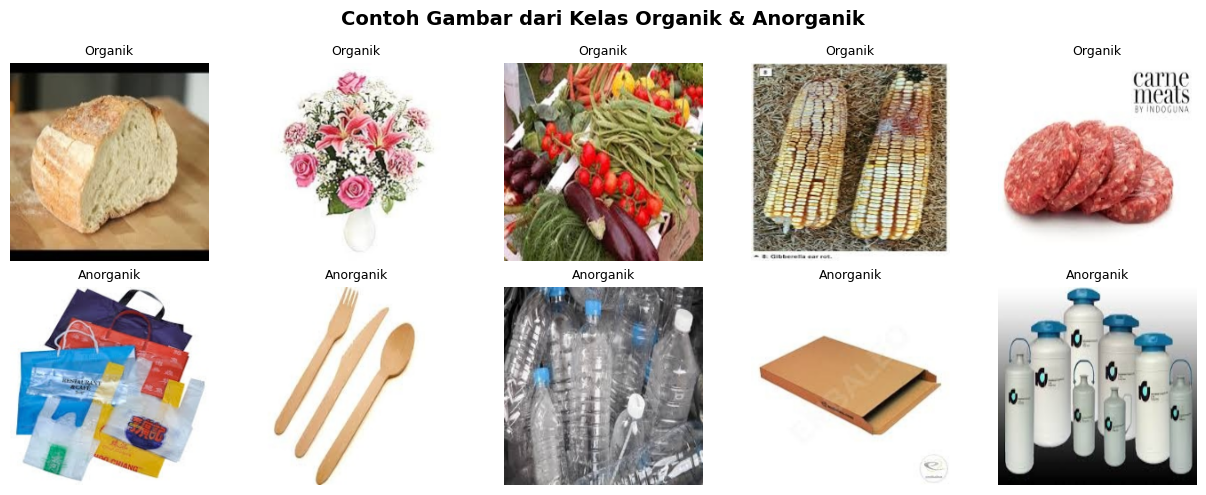

In [23]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

# Path dataset setelah split
train_path = "/content/dataset/train"

# Kategori yang lebih jelas
categories = {"O": "Organik", "R": "Anorganik"}

def show_category_samples(train_path, categories, num_samples=5, img_size=(224, 224)):
    """
    Menampilkan contoh gambar dari setiap kategori.
    Args:
        train_path (str): Path ke dataset train.
        categories (dict): Mapping kategori {kode: nama panjang}.
        num_samples (int): Jumlah sampel per kategori.
        img_size (tuple): Ukuran gambar yang diresize.
    """
    fig, axes = plt.subplots(len(categories), num_samples, figsize=(num_samples * 2.5, len(categories) * 2.5))

    for i, (short_label, full_label) in enumerate(categories.items()):
        class_path = os.path.join(train_path, short_label)

        if not os.path.exists(class_path) or len(os.listdir(class_path)) == 0:
            print(f"⚠️ Folder {full_label} ({class_path}) kosong atau tidak ditemukan!")
            continue  # Skip kalau folder kosong atau tidak ada

        images = os.listdir(class_path)
        selected_images = random.sample(images, min(num_samples, len(images)))  # Ambil max 5 gambar

        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)  # Resize biar konsisten

            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            axes[i, j].set_title(f"{full_label}", fontsize=9)

    plt.suptitle("Contoh Gambar dari Kelas Organik & Anorganik", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk menampilkan gambar
show_category_samples(train_path, categories, num_samples=5)

#### Augmentasi

In [24]:
# Path Dataset
original_path = "/content/dataset/train/"  # Gunakan dataset train untuk augmentasi
augmented_path = "/content/dataset/train_augmented/"  # Simpan hasil augmentasi di sini

os.makedirs(augmented_path, exist_ok=True)

def blur_image(img):
    """Menerapkan Gaussian Blur ke gambar."""
    return cv2.GaussianBlur(img, (5, 5), 0)

def rotate_random(img):
    """Memutar gambar secara acak 90° CW, 180°, atau 90° CCW."""
    angle = random.choice([cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE])
    return cv2.rotate(img, angle)

def warp_shift(img):
    """Melakukan transformasi afine untuk menggeser posisi gambar."""
    rows, cols, _ = img.shape
    src_points = np.float32([[0, 0], [cols, 0], [0, rows]])
    dst_points = np.float32([[cols * 0.1, rows * 0.2], [cols * 0.9, 0], [cols * 0.2, rows]])
    M = cv2.getAffineTransform(src_points, dst_points)
    return cv2.warpAffine(img, M, (cols, rows))

def augment_dataset(original_path, augmented_path):
    """
    Melakukan augmentasi dataset dengan teknik manual.

    Args:
        original_path (str): Path ke dataset asli.
        augmented_path (str): Path untuk menyimpan hasil augmentasi.

    Returns:
        None: Semua gambar hasil augmentasi akan disimpan dalam folder yang ditentukan.
    """
    for class_folder in os.listdir(original_path):  # Loop untuk setiap kelas
        class_path = os.path.join(original_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        # Buat folder di augmented_path untuk kelas ini
        class_aug_path = os.path.join(augmented_path, class_folder)
        os.makedirs(class_aug_path, exist_ok=True)

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"❌ File {img_path} tidak bisa dibaca, dilewati.")
                continue

            # Terapkan augmentasi
            augmented_images = [
                blur_image(img),
                rotate_random(img),
                warp_shift(img)
            ]

            # Simpan hasil augmentasi
            for i, aug_img in enumerate(augmented_images):
                aug_img_path = os.path.join(class_aug_path, f"{img_name.split('.')[0]}_aug_{i}.jpg")
                cv2.imwrite(aug_img_path, img_as_ubyte(aug_img))

    print("✅ Proses augmentasi selesai!")

# Jalankan augmentasi
augment_dataset(original_path, augmented_path)

✅ Proses augmentasi selesai!


## ImageDataGenerator

In [26]:
#########################################
# 2. Setup Data Generator
#
# Deskripsi:
# - Membuat generator data untuk training, validasi, dan testing.
# - Augmentasi hanya diterapkan pada data training untuk meningkatkan generalisasi model.
# - Data validasi dan testing hanya dinormalisasi tanpa augmentasi.
#
# Catatan:
# - Augmentasi meliputi rotasi, pergeseran, zoom, shear, dan flip horizontal.
# - Data validasi dan testing tetap murni agar evaluasi akurat.
#########################################


# Path dataset setelah diproses
TRAIN_DIR = "/content/dataset/train/"  # Dataset untuk training
VALID_DIR = "/content/dataset/val/"    # Dataset untuk validasi
TEST_DIR = "/content/dataset/test/"    # Dataset untuk testing

# Data Augmentation untuk meningkatkan generalisasi model
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalisasi nilai piksel ke [0,1]
    rotation_range=20,        # Rotasi acak hingga 20 derajat
    width_shift_range=0.2,    # Pergeseran horizontal hingga 20% lebar gambar
    height_shift_range=0.2,   # Pergeseran vertikal hingga 20% tinggi gambar
    shear_range=0.2,          # Transformasi geser hingga 20%
    zoom_range=0.2,           # Zoom in/out hingga 20%
    horizontal_flip=True,     # Flip horizontal secara acak
    fill_mode='nearest'       # Metode pengisian piksel kosong setelah transformasi
)

# Generator untuk validasi dan testing (tanpa augmentasi, hanya normalisasi)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Train Generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,          # Jumlah gambar per batch
    target_size=(224, 224), # Ukuran gambar yang di-resize
    color_mode="rgb",       # Gambar berwarna (RGB)
    class_mode='binary',    # Output berupa 1 atau 0 (klasifikasi biner)
    shuffle=True            # Acak urutan data setiap epoch
)

# Validation Generator
validation_generator = valid_test_datagen.flow_from_directory(
    VALID_DIR,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='binary',
    shuffle=False  # Tidak perlu shuffle untuk validasi
)

# Test Generator
test_generator = valid_test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,  # Batch size 1 agar prediksi bisa dilakukan per gambar
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='binary',
    shuffle=False  # Tidak perlu shuffle untuk testing
)

# Print informasi dataset
print("Total gambar di Training set:", train_generator.samples)
print("Total gambar di Validation set:", validation_generator.samples)
print("Total gambar di Test set:", test_generator.samples)
print("✅ Data preprocessing selesai! Siap ke tahap training 🚀")


Found 18051 images belonging to 2 classes.
Found 2256 images belonging to 2 classes.
Found 2257 images belonging to 2 classes.
Total gambar di Training set: 18051
Total gambar di Validation set: 2256
Total gambar di Test set: 2257
✅ Data preprocessing selesai! Siap ke tahap training 🚀


## Modelling

In [27]:
#########################################
# 3. Setup Callback untuk Training Model
#
# Callback digunakan untuk meningkatkan efisiensi training dan mencegah overfitting:
# - EarlyStopping: Menghentikan training jika val_loss tidak membaik setelah beberapa epoch.
# - ReduceLROnPlateau: Mengurangi learning rate jika val_loss stagnan untuk meningkatkan konvergensi.
# - ModelCheckpoint: Menyimpan bobot model terbaik berdasarkan val_loss terendah.
# - TensorBoard: (Opsional) Logging untuk visualisasi training menggunakan TensorBoard.
#
# Parameter utama:
# - patience=5 (EarlyStopping) → Model berhenti jika tidak ada perbaikan dalam 5 epoch.
# - factor=0.8 (ReduceLROnPlateau) → Learning rate dikurangi 20% jika val_loss stagnan.
# - min_lr=1e-6 → Batas minimum learning rate agar tidak terlalu kecil.
#########################################

# Callback Early Stopping untuk menghentikan training lebih awal jika val_loss stagnan
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

# Callback ReduceLROnPlateau untuk menurunkan learning rate saat training stagnan
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=3,
    mode='min',
    min_lr=1e-6,
    verbose=1
)

# Callback ModelCheckpoint untuk menyimpan model terbaik berdasarkan val_loss
model_checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode='min',
    verbose=1
)

# Callback TensorBoard untuk logging (opsional, bisa diaktifkan saat debugging/tracking training)
log_dir = "logs"
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True
)

# Gabungkan semua callback dalam satu list
callbacks = [early_stopping, reduce_lr, model_checkpoint, tensorboard_callback]


In [28]:
#########################################
# 3. Build & Compile Model
#
# Model menggunakan transfer learning dengan MobileNetV2 sebagai feature extractor:
# - Base model: MobileNetV2 (pretrained dari ImageNet, tanpa FC layer terakhir).
# - Fully Connected Head:
#   - GlobalAveragePooling2D → Mengurangi dimensi tanpa kehilangan informasi penting.
#   - BatchNormalization → Membantu stabilisasi training dengan normalisasi distribusi aktivasi.
#   - Dropout → Mencegah overfitting (0.3 setelah pooling, 0.2 setelah hidden layer).
#   - Dense(128, ReLU) → Layer hidden untuk pembelajaran fitur tambahan.
#   - Dense(1, Sigmoid) → Output layer untuk klasifikasi biner (Organik vs Anorganik).
#
# **Fine-tuning strategy**:
# - Pada fase awal, base model **dibekukan** (trainable=False) agar hanya kepala model yang dilatih.
# - Setelah beberapa epoch, bisa di-unfreeze untuk fine-tuning jika hasilnya masih kurang optimal.
#
# **Hyperparameters**:
# - Learning rate = 0.0001 (Adam Optimizer) → Stabil dan cepat konvergen.
# - Loss function = Binary Crossentropy → Sesuai untuk klasifikasi biner.
#########################################

# Load MobileNetV2 tanpa fully connected layer terakhir
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model untuk fase awal training

# Custom head untuk klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling untuk mengurangi dimensi
x = BatchNormalization()(x)  # Normalisasi agar training lebih stabil
x = Dropout(0.3)(x)  # Dropout untuk mengurangi overfitting
x = Dense(128, activation="relu")(x)  # Fully connected layer utama
x = Dropout(0.2)(x)  # Dropout tambahan setelah hidden layer
output = Dense(1, activation="sigmoid")(x)  # Output layer (biner)

# Buat model akhir
model = Model(inputs=base_model.input, outputs=output)

# Compile model dengan Adam optimizer dan binary crossentropy
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Tampilkan ringkasan model
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,427,201 (9.26 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [34]:
# Pastikan kelas ada di TRAIN_DIR
class_labels = ["O", "R"]
class_counts = {}

for label in class_labels:
    class_path = os.path.join(TRAIN_DIR, label)
    if os.path.exists(class_path) and os.path.isdir(class_path):
        class_counts[label] = len(os.listdir(class_path))
    else:
        class_counts[label] = 0  # Hindari error kalau folder kosong/tidak ada

# Pastikan dataset tidak kosong sebelum lanjut
total_images = sum(class_counts.values())
if total_images == 0:
    raise ValueError("Dataset kosong! Tidak bisa menghitung class weights.")

# Hitung class weights (manual)
class_weights = {
    0: (1 / max(class_counts["O"], 1)) * (total_images / 2.0),
    1: (1 / max(class_counts["R"], 1)) * (total_images / 2.0)
}

# Hitung class weights (sklearn) jika y_labels tidak kosong
y_labels = np.array([0] * class_counts["O"] + [1] * class_counts["R"])
sklearn_class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=y_labels)
class_weights_sklearn = dict(enumerate(sklearn_class_weights))

print(f"Class Weights (manual):    {class_weights[0]:.6f}, {class_weights[1]:.6f}")
print(f"Class Weights (sklearn):   {class_weights_sklearn[0]:.6f}, {class_weights_sklearn[1]:.6f}")


Class Weights (manual):    0.897881, 1.128329
Class Weights (sklearn):   0.897881, 1.128329


In [35]:
history = model.fit(
    train_generator,
    epochs=50,  # Jumlah epoch maksimum
    validation_data=validation_generator,  # Data validasi
    class_weight=class_weights,  # Gunakan class weights agar training lebih adil
    callbacks=callbacks  # Callback untuk early stopping, lr scheduling, model checkpoint, dll.
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8082 - loss: 0.4339
Epoch 1: val_loss improved from inf to 0.20423, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 258s 434ms/step - accuracy: 0.8083 - loss: 0.4337 - val_accuracy: 0.9198 - val_loss: 0.2042 - learning_rate: 1.0000e-04
Epoch 2/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9013 - loss: 0.2556
Epoch 2: val_loss improved from 0.20423 to 0.18358, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 229s 405ms/step - accuracy: 0.9013 - loss: 0.2556 - val_accuracy: 0.9300 - val_loss: 0.1836 - learning_rate: 1.0000e-04
Epoch 3/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9069 - loss: 0.2396
Epoch 3: val_loss improved from 0.18358 to 0.17694, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 231s 408ms/step - accuracy: 0.9069 - loss: 0.2396 - val_accuracy: 0.9335 - val_loss: 0.1769 - learning_rate: 1.0000e-04
Epoch 4/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9138 - loss: 0.2193
Epoch 4: val_loss improved from 0.17694 to 0.16967, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 223s 394ms/step - accuracy: 0.9138 - loss: 0.2193 - val_accuracy: 0.9344 - val_loss: 0.1697 - learning_rate: 1.0000e-04
Epoch 5/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9176 - loss: 0.2067
Epoch 5: val_loss improved from 0.16967 to 0.16682, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 227s 401ms/step - accuracy: 0.9176 - loss: 0.2067 - val_accuracy: 0.9379 - val_loss: 0.1668 - learning_rate: 1.0000e-04
Epoch 6/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9231 - loss: 0.1992
Epoch 6: val_loss improved from 0.16682 to 0.16406, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 225s 398ms/step - accuracy: 0.9231 - loss: 0.1992 - val_accuracy: 0.9393 - val_loss: 0.1641 - learning_rate: 1.0000e-04
Epoch 7/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9262 - loss: 0.1905
Epoch 7: val_loss improved from 0.16406 to 0.15604, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 221s 391ms/step - accuracy: 0.9262 - loss: 0.1905 - val_accuracy: 0.9450 - val_loss: 0.1560 - learning_rate: 1.0000e-04
Epoch 8/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9277 - loss: 0.1856
Epoch 8: val_loss improved from 0.15604 to 0.15205, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 268s 402ms/step - accuracy: 0.9277 - loss: 0.1856 - val_accuracy: 0.9441 - val_loss: 0.1521 - learning_rate: 1.0000e-04
Epoch 9/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9295 - loss: 0.1862
Epoch 9: val_loss improved from 0.15205 to 0.14750, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 223s 394ms/step - accuracy: 0.9295 - loss: 0.1862 - val_accuracy: 0.9446 - val_loss: 0.1475 - learning_rate: 1.0000e-04
Epoch 10/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9313 - loss: 0.1707
Epoch 10: val_loss did not improve from 0.14750
565/565 ━━━━━━━━━━━━━━━━━━━━ 220s 390ms/step - accuracy: 0.9313 - loss: 0.1707 - val_accuracy: 0.9446 - val_loss: 0.1513 - learning_rate: 1.0000e-04
Epoch 11/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9325 - loss: 0.1693
Epoch 11: val_loss improved from 0.14750 to 0.14509, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 218s 386ms/step - accuracy: 0.9325 - loss: 0.1693 - val_accuracy: 0.9486 - val_loss: 0.1451 - learning_rate: 1.0000e-04
Epoch 12/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9368 - loss: 0.1641
Epoch 12: val_loss did not improve from 0.14509
565/565 ━━━━━━━━━━━━━━━━━━━━ 220s 390ms/step - accuracy: 0.9368 - loss: 0.1641 - val_accuracy: 0.9477 - val_loss: 0.1483 - learning_rate: 1.0000e-04
Epoch 13/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9351 - loss: 0.1663
Epoch 13: val_loss improved from 0.14509 to 0.14403, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 220s 389ms/step - accuracy: 0.9351 - loss: 0.1663 - val_accuracy: 0.9490 - val_loss: 0.1440 - learning_rate: 1.0000e-04
Epoch 14/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9395 - loss: 0.1577
Epoch 14: val_loss did not improve from 0.14403
565/565 ━━━━━━━━━━━━━━━━━━━━ 220s 389ms/step - accuracy: 0.9395 - loss: 0.1577 - val_accuracy: 0.9499 - val_loss: 0.1440 - learning_rate: 1.0000e-04
Epoch 15/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9384 - loss: 0.1564
Epoch 15: val_loss did not improve from 0.14403
565/565 ━━━━━━━━━━━━━━━━━━━━ 259s 383ms/step - accuracy: 0.9384 - loss: 0.1564 - val_accuracy: 0.9499 - val_loss: 0.1459 - learning_rate: 1.0000e-04
Epoch 16/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9373 - loss: 0.1595
Epoch 16: val_loss improved from 0.14403 to 0.14321, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 216s 382ms/step - accuracy: 0.9373 - loss: 0.1595 - val_accuracy: 0.9481 - val_loss: 0.1432 - learning_rate: 1.0000e-04
Epoch 17/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9411 - loss: 0.1519
Epoch 17: val_loss improved from 0.14321 to 0.13925, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 220s 390ms/step - accuracy: 0.9411 - loss: 0.1519 - val_accuracy: 0.9526 - val_loss: 0.1392 - learning_rate: 1.0000e-04
Epoch 18/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9409 - loss: 0.1523
Epoch 18: val_loss improved from 0.13925 to 0.13653, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 220s 390ms/step - accuracy: 0.9409 - loss: 0.1523 - val_accuracy: 0.9526 - val_loss: 0.1365 - learning_rate: 1.0000e-04
Epoch 19/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9416 - loss: 0.1460
Epoch 19: val_loss improved from 0.13653 to 0.13518, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 217s 384ms/step - accuracy: 0.9416 - loss: 0.1460 - val_accuracy: 0.9539 - val_loss: 0.1352 - learning_rate: 1.0000e-04
Epoch 20/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9447 - loss: 0.1416
Epoch 20: val_loss did not improve from 0.13518
565/565 ━━━━━━━━━━━━━━━━━━━━ 214s 379ms/step - accuracy: 0.9447 - loss: 0.1416 - val_accuracy: 0.9535 - val_loss: 0.1381 - learning_rate: 1.0000e-04
Epoch 21/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9447 - loss: 0.1458
Epoch 21: val_loss did not improve from 0.13518
565/565 ━━━━━━━━━━━━━━━━━━━━ 218s 386ms/step - accuracy: 0.9447 - loss: 0.1458 - val_accuracy: 0.9543 - val_loss: 0.1355 - learning_rate: 1.0000e-04
Epoch 22/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9490 - loss: 0.1363
Epoch 22: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.

Epoch 22: val_loss did not improve from 0.13518
565/565 ━━━━━━━━━━━━━━━━━━━━ 217s 384ms/step - accuracy: 0.9490 

565/565 ━━━━━━━━━━━━━━━━━━━━ 267s 394ms/step - accuracy: 0.9526 - loss: 0.1253 - val_accuracy: 0.9557 - val_loss: 0.1308 - learning_rate: 8.0000e-05
Epoch 25/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9464 - loss: 0.1401
Epoch 25: val_loss did not improve from 0.13084
565/565 ━━━━━━━━━━━━━━━━━━━━ 224s 396ms/step - accuracy: 0.9464 - loss: 0.1401 - val_accuracy: 0.9548 - val_loss: 0.1340 - learning_rate: 8.0000e-05
Epoch 26/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9493 - loss: 0.1346
Epoch 26: val_loss did not improve from 0.13084
565/565 ━━━━━━━━━━━━━━━━━━━━ 222s 394ms/step - accuracy: 0.9493 - loss: 0.1346 - val_accuracy: 0.9535 - val_loss: 0.1332 - learning_rate: 8.0000e-05
Epoch 27/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9484 - loss: 0.1342
Epoch 27: ReduceLROnPlateau reducing learning rate to 6.399999838322402e-05.

Epoch 27: val_loss did not improve from 0.13084
565/565 ━━━━━━━━━━━━━━━━━━━━ 221s 392ms/step - accuracy: 0.9484 

In [36]:
# Muat model yang sudah disimpan sebelumnya
model = tf.keras.models.load_model("best_model.h5")

# Bungkus model dengan class agar bisa disimpan dalam Pickle/Joblib
class KerasModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        return self.model.predict(X)

    def __getstate__(self):
        """Serialize model before pickling"""
        model_path = "temp_model.h5"
        self.model.save(model_path)
        return {"model_path": model_path}

    def __setstate__(self, state):
        """Deserialize model after unpickling"""
        self.model = tf.keras.models.load_model(state["model_path"])

# Simpan ke Pickle
wrapped_model = KerasModelWrapper(model)
joblib.dump(wrapped_model, "model.pkl")

print("Model disimpan sebagai model.pkl menggunakan Joblib.")


Model disimpan sebagai model.pkl menggunakan Joblib.


## Evaluasi dan Visualisasi

2257/2257 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step
Classification Report:

                  precision    recall  f1-score   support

Sampah Anorganik     0.9682    0.9459    0.9569      1257
  Sampah Organik     0.9339    0.9610    0.9473      1000

        accuracy                         0.9526      2257
       macro avg     0.9511    0.9535    0.9521      2257
    weighted avg     0.9530    0.9526    0.9527      2257



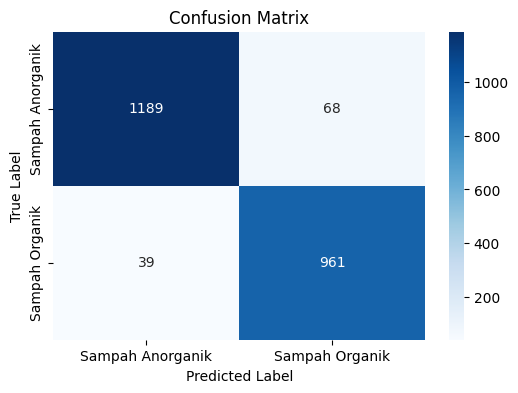

In [37]:
# Pastikan test_generator sudah di-reset
test_generator.reset()

# Lakukan prediksi pada test set
predictions = model.predict(test_generator, verbose=1)

# Karena model binary, kita gunakan threshold 0.5
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)
true_labels = test_generator.classes

# Tampilkan classification report
target_names = ['Sampah Anorganik', 'Sampah Organik']
print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=target_names, digits=4))

# Buat confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

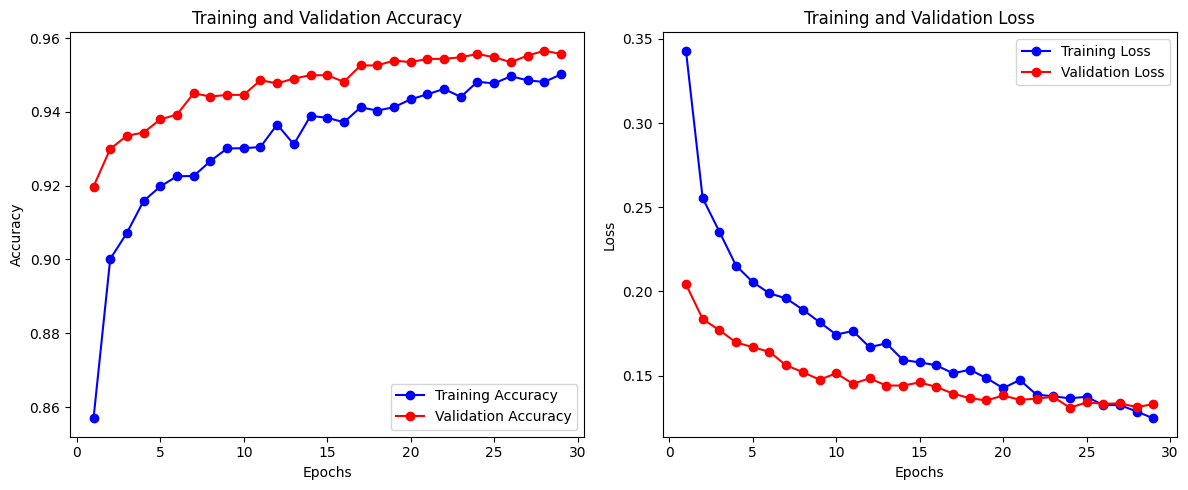

In [38]:
# Visualisasi grafik training (akurasi & loss)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
# Plot akurasi training dan validasi
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss training dan validasi
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

#### SavedModel


In [39]:
# Gunakan model.export() untuk menyimpan model dalam format SavedModel
model.export("saved_model_trashlab")
print("Model berhasil disimpan sebagai SavedModel di 'saved_model_trashlab'.")

Saved artifact at 'saved_model_trashlab'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132153733182288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132153733182480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132153733179600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132153733183248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132153733184976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132153733177488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132153733177872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132153733182096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132153733179408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132153733184784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13215373317

## Inference

In [40]:
# Di Keras 3, untuk memuat SavedModel sebagai inference-only layer, gunakan TFSMLayer:
loaded_model = tf.keras.layers.TFSMLayer("saved_model_trashlab", call_endpoint="serving_default")
print("Model berhasil dimuat untuk inference.")

Model berhasil dimuat untuk inference.


In [46]:
# Fungsi preprocessing gambar
def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Baca gambar
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB
    img = cv2.resize(img, (224, 224))  # Sesuaikan ukuran dengan model
    img = img / 255.0  # Normalisasi ke range [0,1]
    img = np.expand_dims(img, axis=0).astype(np.float32)  # Pastikan dimensi sesuai
    return img

# Fungsi Prediksi
def predict_savedmodel(image_path):
    img = preprocess_image(image_path)
    prediction = loaded_model(img)

    # Jika output berbentuk dictionary, ambil key yang benar
    if isinstance(prediction, dict):
        prediction = list(prediction.values())[0]

    # Jika output berbentuk tensor, konversi ke numpy
    if isinstance(prediction, tf.Tensor):
        prediction = prediction.numpy()

    print("Output Model:", prediction)  # Debugging

    # **Mapping sesuai class_indices**
    label = "Organik" if prediction[0][0] < 0.5 else "Anorganik"
    confidence = 1 - prediction[0][0] if label == "Organik" else prediction[0][0]

    return label, confidence


# Contoh penggunaan
image_path = "/content/1.jpg"
label, confidence = predict_savedmodel(image_path)
print(f"Prediksi: {label} (Confidence: {confidence:.2f})")

Output Model: [[0.9998779]]
Prediksi: Anorganik (Confidence: 1.00)


In [47]:
print(train_generator.class_indices)

{'O': 0, 'R': 1}
